# X Setup


In [1]:
# =========================
# SETUP CELL
# =========================
from google.colab import drive
import os

drive.mount("/content/drive", force_remount=False)

BASE_DIR = "/content/drive/MyDrive/grunitech-project3-cyberbullying"
DATA_DIR = f"{BASE_DIR}/data"
PROCESSED_DIR = f"{DATA_DIR}/processed"

os.makedirs(PROCESSED_DIR, exist_ok=True)

print("✅ Drive mounted")
print("BASE_DIR:", BASE_DIR)

Mounted at /content/drive
✅ Drive mounted
BASE_DIR: /content/drive/MyDrive/grunitech-project3-cyberbullying


# X Install & imports

In [2]:
import time
import numpy as np
import torch
from collections import deque


## X Re-define SetTransformerDualHead



In [3]:
import torch.nn as nn

class MAB(nn.Module):
    # Multihead Attention Block
    def __init__(self, dim_Q, dim_KV, dim_out, num_heads=4):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim_out, num_heads=num_heads, batch_first=True)
        self.fc_q = nn.Linear(dim_Q, dim_out)
        self.fc_k = nn.Linear(dim_KV, dim_out)
        self.fc_v = nn.Linear(dim_KV, dim_out)

        self.ln1 = nn.LayerNorm(dim_out)
        self.ln2 = nn.LayerNorm(dim_out)

        self.ff = nn.Sequential(
            nn.Linear(dim_out, dim_out),
            nn.ReLU(),
            nn.Linear(dim_out, dim_out)
        )

    def forward(self, Q, KV):
        Q_ = self.fc_q(Q)
        K_ = self.fc_k(KV)
        V_ = self.fc_v(KV)

        H, _ = self.mha(Q_, K_, V_)
        H = self.ln1(H + Q_)
        O = self.ln2(H + self.ff(H))
        return O


class ISAB(nn.Module):
    # Induced Set Attention Block (corrected)
    def __init__(self, dim_in, dim_out, num_heads=4, num_inducing=16):
        super().__init__()

        self.proj = nn.Linear(dim_in, dim_out)
        self.I = nn.Parameter(torch.randn(1, num_inducing, dim_out))

        # Both MABs now operate in dim_out space
        self.mab1 = MAB(
            dim_Q=dim_out,
            dim_KV=dim_out,
            dim_out=dim_out,
            num_heads=num_heads
        )

        self.mab2 = MAB(
            dim_Q=dim_out,
            dim_KV=dim_out,
            dim_out=dim_out,
            num_heads=num_heads
        )

    def forward(self, X):
        # X: [B, N, dim_in]
        Xp = self.proj(X)             # [B, N, dim_out]
        B = Xp.size(0)
        I = self.I.expand(B, -1, -1)  # [B, m, dim_out]

        H = self.mab1(I, Xp)          # [B, m, dim_out]
        O = self.mab2(Xp, H)          # [B, N, dim_out]
        return O


class PMA(nn.Module):
    # Pooling by Multihead Attention
    def __init__(self, dim, num_heads=4, num_seeds=1):
        super().__init__()
        self.S = nn.Parameter(torch.randn(1, num_seeds, dim))
        self.mab = MAB(dim_Q=dim, dim_KV=dim, dim_out=dim, num_heads=num_heads)

    def forward(self, X):
        B = X.size(0)
        S = self.S.expand(B, -1, -1)
        return self.mab(S, X)  # [B, num_seeds, dim]


In [4]:
# --- Add split between Single Head SetTransformer and Dual Head Transformer

class SetTransformerDualHead(nn.Module):
    def __init__(self, dim_in=384, dim=256, num_heads=4, num_inducing=16):
        super().__init__()
        self.enc1 = ISAB(dim_in, dim, num_heads, num_inducing)
        self.enc2 = ISAB(dim, dim, num_heads, num_inducing)
        self.pool = PMA(dim, num_heads, num_seeds=1)

        trunk = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 128),
            nn.ReLU()
        )
        self.trunk = trunk

        # Two heads
        self.head_mean = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())
        self.head_topk = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())

    def forward(self, X):
        H = self.enc1(X)
        H = self.enc2(H)
        P = self.pool(H).squeeze(1)      # [B, dim]
        Z = self.trunk(P)                # [B, 128]

        mean_hat = self.head_mean(Z).squeeze(-1)  # [B]
        topk_hat = self.head_topk(Z).squeeze(-1)  # [B]

        return torch.stack([mean_hat, topk_hat], dim=1)  # [B, 2]


## X Load pre-trained KNN model

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_DIR = f"{BASE_DIR}/models/cluster_model"

model = SetTransformerDualHead().to(device)
model.load_state_dict(torch.load(f"{MODEL_DIR}/settransformer_knn_pretrained.pt"))

<All keys matched successfully>

# X Load 'civil_comments' dataset for simulating live streams

In [6]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import pandas as pd

# Choose a lightweight dataset (small sample)
ds = load_dataset("civil_comments", split="train[:5000]")  # change to [:20000] later if you want
df = pd.DataFrame(ds)[["text", "toxicity"]].dropna()

# Simulate conversation threads (e.g., 200 threads)
rng = np.random.RandomState(42)
df["conv_id"] = rng.randint(0, 200, size=len(df))

# Simulate arrival times (seconds)
start_ts = 0
df["ts"] = np.cumsum(rng.exponential(scale=1.5, size=len(df))).astype(np.float32)  # average 1.5s between msgs

df.head()

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/97320 [00:00<?, ? examples/s]

,text,toxicity,conv_id,ts
0,"This is so cool. It's like, 'would you want yo...",0.000000,102,0.886431
1,Thank you!! This would make my life a lot less...,0.000000,179,3.345075
2,This is such an urgent design problem; kudos t...,0.000000,92,3.357069
3,Is this something I'll be able to install on m...,0.000000,14,7.233717
4,haha you guys are a bunch of losers.,0.893617,106,8.112328


## X Inject synthetic raids

In [7]:
import pandas as pd
import numpy as np

def inject_raid(df, raid_start_idx=2000, raid_size=30, dt=0.2, conv_id=999, tox_th=0.85, seed=42):
    rng = np.random.RandomState(seed)

    # choose a toxic template
    toxic_pool = df[df["toxicity"] >= tox_th]
    if len(toxic_pool) == 0:
        raise ValueError("No toxic samples found above threshold; lower tox_th.")

    raid_msg = toxic_pool.sample(1, random_state=seed).iloc[0]["text"]

    base_ts = float(df.loc[raid_start_idx, "ts"])

    raid_rows = []
    for j in range(raid_size):
        # slight text perturbation helps simulate real raids without changing semantics too much
        suffix = ["!!", " 😂", " bro", " lol", " 🙄", " ..."][j % 6]
        raid_rows.append({
            "text": raid_msg + suffix,
            "toxicity": float(raid_msg and toxic_pool.sample(1, random_state=seed+j).iloc[0]["toxicity"]),  # keep toxic-ish
            "conv_id": conv_id,
            "ts": base_ts + j * dt
        })

    raid_df = pd.DataFrame(raid_rows)

    df_raid = pd.concat([df.iloc[:raid_start_idx], raid_df, df.iloc[raid_start_idx:]], ignore_index=True)
    df_raid = df_raid.sort_values("ts").reset_index(drop=True)
    return df_raid

df = inject_raid(df, raid_start_idx=2000, raid_size=40, dt=0.15, conv_id=999, tox_th=0.85)
print("df after raid:", df.shape)


df after raid: (5040, 4)


# X Encode text

In [8]:
from sentence_transformers import SentenceTransformer

encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

embeddings = encoder.encode(
    df["text"].tolist(),
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

df["embedding"] = list(embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

# X Add unique message IDs (for group referencing)

In [12]:
# Give each message a stable id
df = df.reset_index(drop=True)
df["msg_id"] = np.arange(len(df), dtype=np.int32)

# X Define context (buffer-based, simple + production-like)

In [13]:
from collections import deque
import numpy as np
import torch

CTX_MAXLEN = 50        # context set size (like "last 50 msgs")
TOX_TH = 0.5           # what counts as "toxic" in ground-truth (for stats only)
TOPK_SHOW = 10         # store top contributors (IDs + snippets)
EPS = 1e-9


# X Streaming inference (dual-head model)

This includes:

ctx_size / ctx_time_span / ctx_density

ctx_toxic_frac / ctx_mean_toxicity / ctx_max_toxicity

ctx_conv_ids (unique conv ids in context)

ctx_msg_ids_top (top “contributors” by toxicity)

human explanation

rolling_mean + rolling_conc (as before)

In [25]:
from collections import deque
import pandas as pd

# buffer of embeddings for MODEL INPUT (this is what the SetTransformer needs)
emb_buffer = deque(maxlen=CTX_MAXLEN)

# rolling signals
rolling_mean = 0.0
mean_buffer = deque(maxlen=CTX_MAXLEN)   # used for rolling mean stats (model outputs)
conc_buffer = deque(maxlen=CTX_MAXLEN)   # used for rolling concentration (max)

# context buffer of message indices (what defines the context set)
ctx_idx_buffer = deque(maxlen=CTX_MAXLEN)

outputs = []

model.eval()
with torch.no_grad():
    for _, row in df.iterrows():
        # 0) update context membership first (context includes *current* msg too)
        ctx_idx_buffer.append(int(row["msg_id"]))
        ctx_indices = np.array(ctx_idx_buffer, dtype=np.int32)

        # 1) update MODEL context buffer
        emb_buffer.append(row["embedding"])

        # not enough context yet → skip inference
        if len(emb_buffer) < 5:
            continue

        # 2) model inference on a SET
        X = torch.tensor(
            np.stack(emb_buffer),       # [N, D]
            dtype=torch.float32
        ).unsqueeze(0).to(device)       # [1, N, D]

        y_hat = model(X).cpu().numpy()[0]
        mean_hat = float(y_hat[0])
        conc_hat = float(y_hat[1])

        mean_hat = float(y_hat[0])
        conc_hat = float(y_hat[1])

        # optional clip for safety (if you trained with bounded targets)
        mean_hat = float(np.clip(mean_hat, 0.0, 1.0))
        conc_hat = float(np.clip(conc_hat, 0.0, 1.0))

        # 2) rolling signals
        mean_buffer.append(mean_hat)
        conc_buffer.append(conc_hat)

        rolling_mean = 0.1 * mean_hat + 0.9 * rolling_mean
        rolling_conc = float(np.max(conc_buffer)) if len(conc_buffer) else conc_hat

        # 3) context stats (EXPLAINABILITY)
        ctx_df = df.iloc[ctx_indices]  # context rows
        ctx_tox = ctx_df["toxicity"].to_numpy(dtype=np.float32)
        ctx_ts  = ctx_df["ts"].to_numpy(dtype=np.float32)
        ctx_convs = ctx_df["conv_id"].to_numpy()

        ctx_size = int(len(ctx_df))
        ctx_time_span = float(np.max(ctx_ts) - np.min(ctx_ts)) if ctx_size > 1 else 0.0
        ctx_density = float(ctx_size / (ctx_time_span + EPS))  # msgs per second

        ctx_mean_toxicity = float(np.mean(ctx_tox)) if ctx_size else 0.0
        ctx_max_toxicity  = float(np.max(ctx_tox)) if ctx_size else 0.0
        ctx_toxic_frac    = float(np.mean(ctx_tox > TOX_TH)) if ctx_size else 0.0

        # top “contributors” = most toxic messages in context (by ground truth)
        # (You can later swap toxicity→mean_hat or per-message classifier score.)
        top_idx = np.argsort(ctx_tox)[-TOPK_SHOW:][::-1]  # high→low
        ctx_top_rows = ctx_df.iloc[top_idx]

        ctx_msg_ids_top = ctx_top_rows["msg_id"].tolist()
        ctx_conv_ids = sorted(set(ctx_convs.tolist()))

        # snippets (optional, but super useful for debugging/demos)
        ctx_text_snips = [
            (int(r["msg_id"]), float(r["toxicity"]), str(r["text"])[:120])
            for _, r in ctx_top_rows.iterrows()
        ]

        explanation = (
            f"ctx={ctx_size} msgs / {ctx_time_span:.1f}s | "
            f"density={ctx_density:.2f} msg/s | "
            f"{ctx_toxic_frac*100:.0f}% toxic | "
            f"meanT={ctx_mean_toxicity:.2f} peakT={ctx_max_toxicity:.2f}"
        )

        outputs.append({
            "msg_id": int(row["msg_id"]),
            "ts": float(row["ts"]),
            "conv_id": int(row["conv_id"]),
            "text": str(row["text"]),
            "toxicity": float(row["toxicity"]),

            # model outputs
            "mean_hat": mean_hat,
            "conc_hat": conc_hat,

            # rolling signals
            "rolling_mean": float(rolling_mean),
            "rolling_conc": float(rolling_conc),

            # context explainability
            "ctx_size": ctx_size,
            "ctx_time_span": ctx_time_span,
            "ctx_density": ctx_density,
            "ctx_toxic_frac": ctx_toxic_frac,
            "ctx_mean_toxicity": ctx_mean_toxicity,
            "ctx_max_toxicity": ctx_max_toxicity,
            "ctx_conv_ids": ctx_conv_ids,
            "ctx_msg_ids_top": ctx_msg_ids_top,
            "ctx_top_snips": ctx_text_snips,
            "explanation": explanation,
        })

out_df = pd.DataFrame(outputs)
out_df.head(3)


,msg_id,ts,conv_id,text,toxicity,mean_hat,conc_hat,rolling_mean,rolling_conc,ctx_size,ctx_time_span,ctx_density,ctx_toxic_frac,ctx_mean_toxicity,ctx_max_toxicity,ctx_conv_ids,ctx_msg_ids_top,ctx_top_snips,explanation
0,4,8.112328,106,haha you guys are a bunch of losers.,0.893617,0.586849,0.396109,0.058685,0.396109,5,7.225897,0.691956,0.200000,0.178723,0.893617,"[14, 92, 102, 106, 179]","[4, 3, 2, 1, 0]","[(4, 0.8936170339584351, haha you guys are a b...",ctx=5 msgs / 7.2s | density=0.69 msg/s | 20% t...
1,5,9.321399,71,ur a sh*tty comment.,0.666667,0.586850,0.396109,0.111501,0.396109,6,8.434968,0.711325,0.333333,0.260047,0.893617,"[14, 71, 92, 102, 106, 179]","[4, 5, 3, 2, 1, 0]","[(4, 0.8936170339584351, haha you guys are a b...",ctx=6 msgs / 8.4s | density=0.71 msg/s | 33% t...
2,6,9.762718,188,hahahahahahahahhha suck it.,0.457627,0.586850,0.396109,0.159036,0.396109,7,8.876287,0.788618,0.285714,0.288273,0.893617,"[14, 71, 92, 102, 106, 179, 188]","[4, 5, 6, 3, 2, 1, 0]","[(4, 0.8936170339584351, haha you guys are a b...",ctx=7 msgs / 8.9s | density=0.79 msg/s | 29% t...


# X Add baseline estimation and anomaly signals

In [26]:
# ---- baseline estimation (robust) ----
baseline_mean = np.median(out_df["rolling_mean"])
baseline_conc = np.median(out_df["rolling_conc"])

# ---- anomaly signals ----
out_df["mean_anom"] = out_df["rolling_mean"] - baseline_mean
out_df["conc_anom"] = out_df["rolling_conc"] - baseline_conc

# X Alerting system

In [27]:
MEAN_TH = float(np.quantile(out_df["rolling_mean"], 0.95))
CONC_TH = float(np.quantile(out_df["rolling_conc"], 0.95))

cond_sustained = out_df["rolling_mean"] > MEAN_TH
cond_burst = out_df["rolling_conc"] > CONC_TH

out_df["alert"] = (cond_sustained | cond_burst).astype(int)

out_df["alert_reason"] = np.select(
    [
        cond_burst & cond_sustained,
        cond_burst,
        cond_sustained
    ],
    ["both", "burst", "sustained"],
    default="none"
)

print("Thresholds:", {"MEAN_TH": MEAN_TH, "CONC_TH": CONC_TH})
print("Alerts:", int(out_df["alert"].sum()), "out of", len(out_df))
out_df[out_df["alert"] == 1][
    ["msg_id","ts","conv_id","toxicity","rolling_mean","rolling_conc","alert_reason","explanation"]
].head(10)


Thresholds: {'MEAN_TH': 0.5868507063807551, 'CONC_TH': 0.39610856771469116}
Alerts: 441 out of 5036


,msg_id,ts,conv_id,toxicity,rolling_mean,rolling_conc,alert_reason,explanation
0,4,8.112328,106,0.893617,0.058685,0.396109,burst,ctx=5 msgs / 7.2s | density=0.69 msg/s | 20% t...
1,5,9.321399,71,0.666667,0.111501,0.396109,burst,ctx=6 msgs / 8.4s | density=0.71 msg/s | 33% t...
2,6,9.762718,188,0.457627,0.159036,0.396109,burst,ctx=7 msgs / 8.9s | density=0.79 msg/s | 29% t...
3,7,11.798001,20,0.000000,0.201818,0.396109,burst,ctx=8 msgs / 10.9s | density=0.73 msg/s | 25% ...
4,8,11.917599,102,0.000000,0.240321,0.396109,burst,ctx=9 msgs / 11.0s | density=0.82 msg/s | 22% ...
5,9,15.008656,121,0.000000,0.274974,0.396109,burst,ctx=10 msgs / 14.1s | density=0.71 msg/s | 20%...
6,10,17.650066,74,0.000000,0.306161,0.396109,burst,ctx=11 msgs / 16.8s | density=0.66 msg/s | 18%...
7,11,18.015200,87,0.440000,0.334230,0.396109,burst,ctx=12 msgs / 17.1s | density=0.70 msg/s | 17%...
8,12,20.500973,116,0.000000,0.359492,0.396109,burst,ctx=13 msgs / 19.6s | density=0.66 msg/s | 15%...
9,13,22.816151,99,0.600000,0.382228,0.396109,burst,ctx=14 msgs / 21.9s | density=0.64 msg/s | 21%...


# X Alert source detection

In [28]:
def show_alert_context(out_df, alert_row_idx):
    r = out_df.iloc[alert_row_idx]
    print("ALERT ROW:")
    print(r[["msg_id","ts","conv_id","toxicity","mean_hat","conc_hat","rolling_mean","rolling_conc","alert","alert_reason"]])
    print("\nEXPLANATION:")
    print(r["explanation"])
    print("\nTOP CONTEXT CONTRIBUTORS (msg_id, toxicity, snippet):")
    for mid, tox, snip in r["ctx_top_snips"]:
        print(f"- msg_id={mid} tox={tox:.2f} | {snip}")

# example: show first alert
first_alert_idx = out_df.index[out_df["alert"]==1][0]
show_alert_context(out_df, first_alert_idx)


ALERT ROW:
msg_id                 4
ts              8.112328
conv_id              106
toxicity        0.893617
mean_hat        0.586849
conc_hat        0.396109
rolling_mean    0.058685
rolling_conc    0.396109
alert                  1
alert_reason       burst
Name: 0, dtype: object

EXPLANATION:
ctx=5 msgs / 7.2s | density=0.69 msg/s | 20% toxic | meanT=0.18 peakT=0.89

TOP CONTEXT CONTRIBUTORS (msg_id, toxicity, snippet):
- msg_id=4 tox=0.89 | haha you guys are a bunch of losers.
- msg_id=3 tox=0.00 | Is this something I'll be able to install on my site? When will you be releasing it?
- msg_id=2 tox=0.00 | This is such an urgent design problem; kudos to you for taking it on. Very impressive!
- msg_id=1 tox=0.00 | Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!
- msg_id=0 tox=0.00 | This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!


# X Evaluation plots

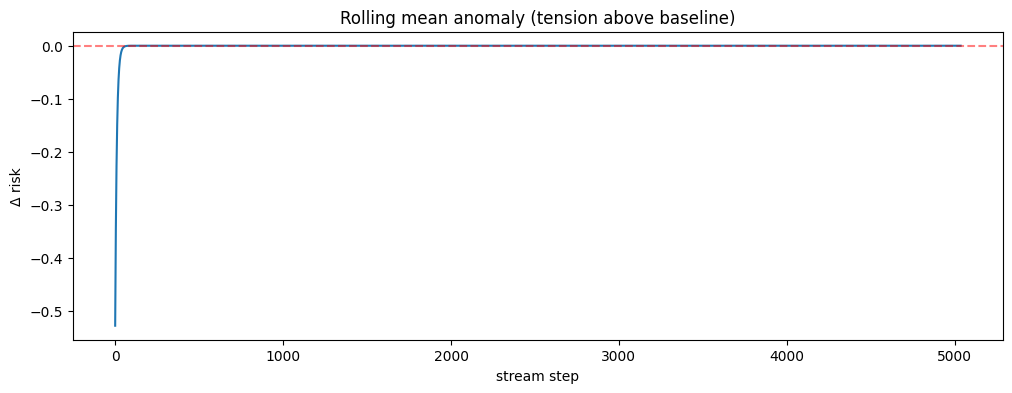

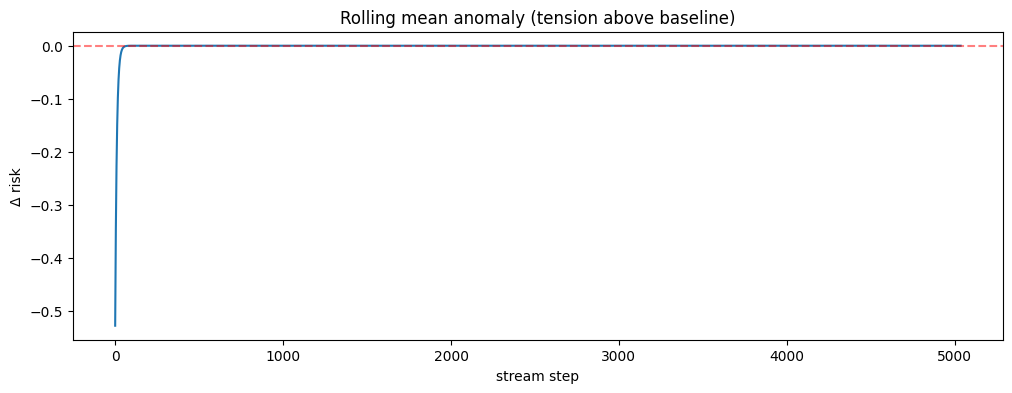

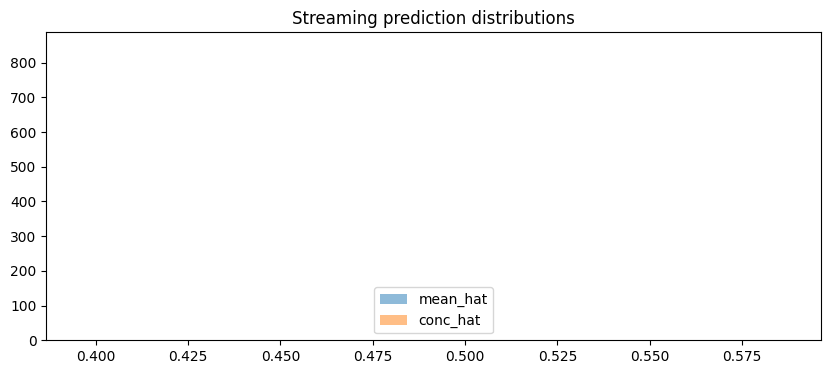

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(out_df["mean_anom"])
plt.axhline(0, color="red", linestyle="--", alpha=0.5)
plt.title("Rolling mean anomaly (tension above baseline)")
plt.xlabel("stream step")
plt.ylabel("Δ risk")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(out_df["mean_anom"])
plt.axhline(0, color="red", linestyle="--", alpha=0.5)
plt.title("Rolling mean anomaly (tension above baseline)")
plt.xlabel("stream step")
plt.ylabel("Δ risk")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(out_df["mean_hat"].values, bins=30, alpha=0.5, label="mean_hat")
plt.hist(out_df["conc_hat"].values, bins=30, alpha=0.5, label="conc_hat")
plt.legend()
plt.title("Streaming prediction distributions")
plt.show()


# X RL


## X Setup

In [32]:
!pip install stable-baselines3 gymnasium

import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 15.1 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## X Build RL environment

In [33]:
class AlertEnv(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.t = 0

        # state: rolling_mean, rolling_conc, density, toxic_frac
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(4,), dtype=np.float32
        )

        # action: 0 = no alert, 1 = alert
        self.action_space = spaces.Discrete(2)

    def reset(self, seed=None, options=None):
        self.t = 0
        return self._get_obs(), {}

    def _get_obs(self):
        r = self.df.iloc[self.t]
        return np.array([
            r["rolling_mean"],
            r["rolling_conc"],
            min(r["ctx_density"], 1.0),
            r["ctx_toxic_frac"],
        ], dtype=np.float32)

    def step(self, action):
        r = self.df.iloc[self.t]
        toxicity = r["toxicity"]

        reward = 0.0
        if action == 1 and toxicity > 0.7:
            reward = +1.0
        elif action == 1 and toxicity <= 0.7:
            reward = -0.5
        elif action == 0 and toxicity > 0.7:
            reward = -0.2

        self.t += 1
        done = self.t >= len(self.df) - 1

        return self._get_obs(), reward, done, False, {}


## X Train PPO

In [34]:
env = AlertEnv(out_df)

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=256,
    batch_size=64,
)

model.learn(total_timesteps=10_000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


----------------------------
| time/              |     |
|    fps             | 338 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 256 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 283         |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 512         |
| train/                  |             |
|    approx_kl            | 0.016444521 |
|    clip_fraction        | 0.00547     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.688      |
|    explained_variance   | -0.00221    |
|    learning_rate        | 0.0003      |
|    loss                 | 4.64        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0188     |
|    value_loss           | 12.6        |
-----------------------------------------
-----------------------------------------

## X Evaluate vs naive threshold

In [35]:
def naive_policy(row):
    return int(
        (row["rolling_mean"] > 0.6) or
        (row["rolling_conc"] > 0.5)
    )


def evaluate_policy(df, policy_fn):
    total = 0
    for _, r in df.iterrows():
        action = policy_fn(r)
        tox = r["toxicity"]

        if action and tox > 0.7:
            total += 1
        elif action and tox <= 0.7:
            total -= 0.5
        elif not action and tox > 0.7:
            total -= 0.2
    return total

print("Naive reward:", evaluate_policy(out_df, naive_policy))

def rl_policy(row):
    obs = np.array([
        row["rolling_mean"],
        row["rolling_conc"],
        min(row["ctx_density"], 1.0),
        row["ctx_toxic_frac"],
    ], dtype=np.float32)
    action, _ = model.predict(obs, deterministic=True)
    return int(action)

print("RL reward:", evaluate_policy(out_df, rl_policy))

Naive reward: -19.79999999999996
RL reward: -19.79999999999996
